# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
import os
import time
import random as python_random
from tqdm import tqdm
from collections import Counter
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

# Color

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

---

# Data Preperation

## Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# 1. Definisikan path folder utama dan path file untuk setiap set data
base_load_path = '/content/drive/MyDrive/TUGAS AKHIR TA/DATA/Clahe_Final_Dataset'
train_file_path = os.path.join(base_load_path, 'Training', 'train_data.npz')
val_file_path = os.path.join(base_load_path, 'Validation', 'val_data.npz')
test_file_path = os.path.join(base_load_path, 'Testing', 'test_data.npz')


# 2. Memuat data latih
with np.load(train_file_path) as data:
    X_train = data['images']
    y_train = data['labels']
print(f"Data Latih berhasil dimuat dari: {train_file_path}")

# 3. Memuat data validasi
with np.load(val_file_path) as data:
    X_val = data['images']
    y_val = data['labels']
print(f"Data Validasi berhasil dimuat dari: {val_file_path}")

# 4. Memuat data uji
with np.load(test_file_path) as data:
    X_test = data['images']
    y_test = data['labels']
print(f"Data Uji berhasil dimuat dari: {test_file_path}")


# --- Verifikasi Data yang Berhasil Dimuat ---
print("\n--- Verifikasi Bentuk dan Tipe Data ---")
print(f"Bentuk X_train: {X_train.shape} | Tipe: {X_train.dtype}")
print(f"Bentuk y_train: {y_train.shape} | Tipe: {y_train.dtype}")
print("-" * 20)
print(f"Bentuk X_val:   {X_val.shape} | Tipe: {X_val.dtype}")
print(f"Bentuk y_val:   {y_val.shape} | Tipe: {y_val.dtype}")
print("-" * 20)
print(f"Bentuk X_test:  {X_test.shape} | Tipe: {X_test.dtype}")
print(f"Bentuk y_test:  {y_test.shape} | Tipe: {y_test.dtype}")
print("\nProses memuat data selesai! ✅")

Mounted at /content/drive
Data Latih berhasil dimuat dari: /content/drive/MyDrive/TUGAS AKHIR TA/DATA/Clahe_Final_Dataset/Training/train_data.npz
Data Validasi berhasil dimuat dari: /content/drive/MyDrive/TUGAS AKHIR TA/DATA/Clahe_Final_Dataset/Validation/val_data.npz
Data Uji berhasil dimuat dari: /content/drive/MyDrive/TUGAS AKHIR TA/DATA/Clahe_Final_Dataset/Testing/test_data.npz

--- Verifikasi Bentuk dan Tipe Data ---
Bentuk X_train: (8000, 224, 224, 3) | Tipe: uint8
Bentuk y_train: (8000,) | Tipe: <U10
--------------------
Bentuk X_val:   (1000, 224, 224, 3) | Tipe: uint8
Bentuk y_val:   (1000,) | Tipe: <U10
--------------------
Bentuk X_test:  (1000, 224, 224, 3) | Tipe: uint8
Bentuk y_test:  (1000,) | Tipe: <U10

Proses memuat data selesai! ✅


## One Hot Encoding

In [4]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# 1. Inisialisasi LabelEncoder
le = LabelEncoder()

# 2. Fit encoder pada data latih dan transformasikan (Belajar dari y_train)
# Ini mengubah label string menjadi angka (misal: 'glioma' -> 0, 'meningioma' -> 1, dst.)
y_train = le.fit_transform(y_train )

# 3. Gunakan encoder yang SAMA untuk mengubah data validasi dan uji
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# --- Verifikasi hasil Label Encoding (Teks -> Angka) ---
print("\nPemetaan yang dipelajari oleh LabelEncoder:")
# Menampilkan kelas-kelas unik dan urutannya
for index, class_name in enumerate(le.classes_):
    print(f"- Angka {index}  -->  '{class_name}'")

# 4. Lakukan One-Hot Encoding pada semua data yang sudah menjadi angka
num_classes = len(le.classes_)
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Menampilkan bentuk akhir dari semua array
print("\nBentuk data final yang siap untuk training:")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}   | y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}  | y_test:  {y_test.shape}")

print("\nProses encoding selesai! ✅")


Pemetaan yang dipelajari oleh LabelEncoder:
- Angka 0  -->  'glioma'
- Angka 1  -->  'meningioma'
- Angka 2  -->  'notumor'
- Angka 3  -->  'pituitary'

Bentuk data final yang siap untuk training:
X_train: (8000, 224, 224, 3) | y_train: (8000, 4)
X_val:   (1000, 224, 224, 3)   | y_val:   (1000, 4)
X_test:  (1000, 224, 224, 3)  | y_test:  (1000, 4)

Proses encoding selesai! ✅


## Transfer Learning & Architecture Model

In [5]:
image_size = 224
effnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

model_output = effnet.output
model_output = tf.keras.layers.GlobalAveragePooling2D()(model_output)
model_output = tf.keras.layers.Dropout(rate=0.50)(model_output)
model_output = tf.keras.layers.BatchNormalization()(model_output)
model_output = tf.keras.layers.Dense(4, activation='softmax')(model_output)
model = tf.keras.models.Model(inputs=effnet.input, outputs=model_output)
model.summary()

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("brain-final.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,059,815 (15.49 MB)

 Trainable params: 4,015,232 (15.32 MB)

 Non-trainable params: 44,583 (174.16 KB)

## Training The Model

In [6]:
start_time = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs= 12,
    batch_size= 64,
    callbacks=[
        tensorboard,
        checkpoint
        ]
)

end_time = time.time()
training_time = end_time - start_time
print(f"\nTotal Waktu Pelatihan: {training_time:.2f} detik ({training_time/60:.2f} menit)")

Epoch 1/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8195 - loss: 0.5085
Epoch 1: val_accuracy improved from -inf to 0.91700, saving model to brain-final.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 140s 421ms/step - accuracy: 0.8201 - loss: 0.5070 - val_accuracy: 0.9170 - val_loss: 0.2697
Epoch 2/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9685 - loss: 0.0984
Epoch 2: val_accuracy improved from 0.91700 to 0.93600, saving model to brain-final.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 238ms/step - accuracy: 0.9685 - loss: 0.0984 - val_accuracy: 0.9360 - val_loss: 0.2584
Epoch 3/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9816 - loss: 0.0550
Epoch 3: val_accuracy improved from 0.93600 to 0.95100, saving model to brain-final.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 42s 247ms/step - accuracy: 0.9816 - loss: 0.0550 - val_accuracy: 0.9510 - val_loss: 0.2201
Epoch 4/12
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9825 - loss: 0.0524
Epoch 4: val_accurac

# Prediction Accuracy

- Angka 0  -->  'glioma'
- Angka 1  -->  'meningioma'
- Angka 2  -->  'notumor'
- Angka 3  -->  'pituitary'

In [7]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test, axis=1)

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
print("\n--- Laporan Klasifikasi ---")
print(classification_report(y_test_new, pred, target_names=labels))

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step

--- Laporan Klasifikasi ---
              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       250
  meningioma       0.97      0.98      0.97       250
     notumor       0.99      1.00      0.99       250
   pituitary       0.99      0.98      0.99       250

    accuracy                           0.98      1000
   macro avg       0.99      0.98      0.99      1000
weighted avg       0.99      0.98      0.99      1000



## Result

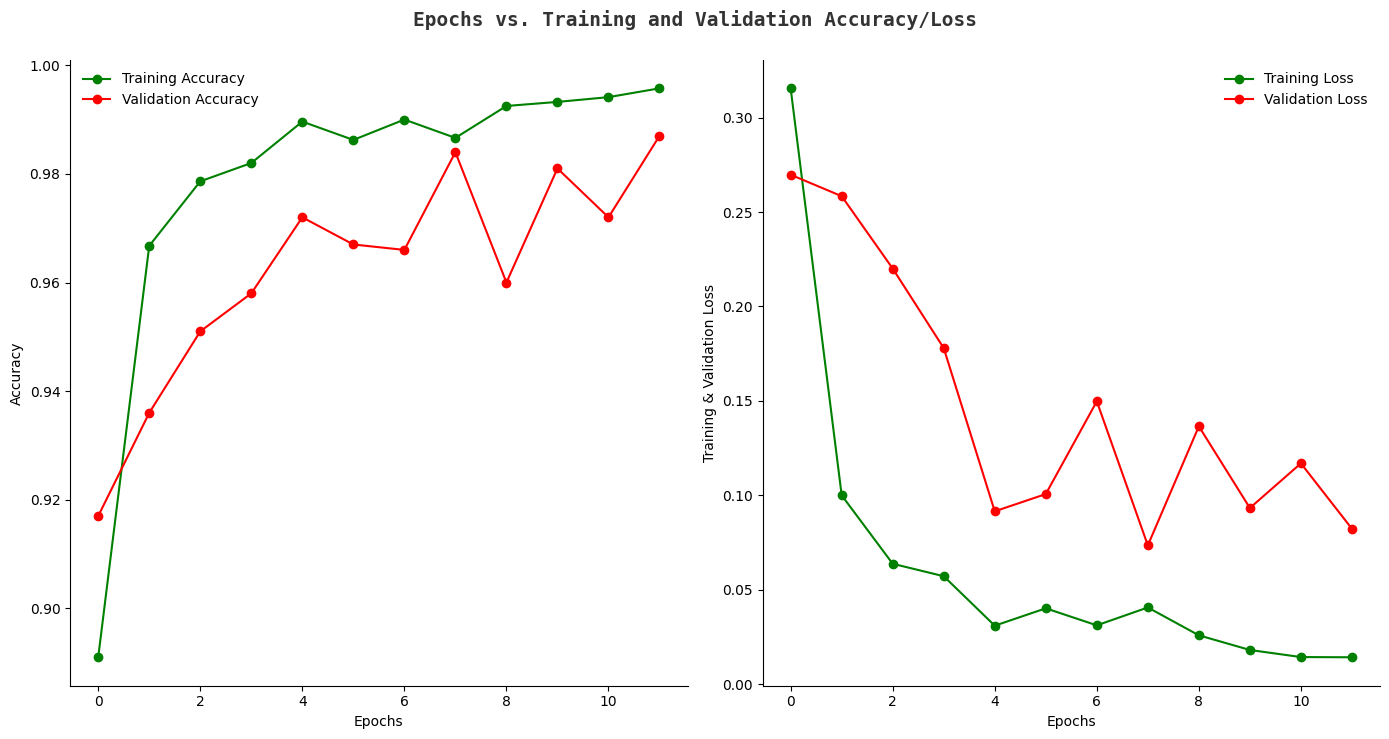

In [8]:
from warnings import filterwarnings

filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=14,fontweight='bold',
             fontname='monospace',color='black',y=1.02,x=0.5,alpha=0.8, ha='center', va='bottom')

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor='green',color='green',
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor='red',color='red',
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor='green',color='green',
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor='red',color='red',
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

plt.tight_layout()
fig.show()

In [9]:
# Melihat daftar akurasi dari data train dan data validasi dari setiap epoch
print("Accuracy:")
for epoch in range(len(history.history['accuracy'])):
  print(f"Epoch {epoch+1} : Training = {history.history['accuracy'][epoch]:.4f}, Validation = {history.history['val_accuracy'][epoch]:.4f}")

print("\nLoss:")
for epoch in range(len(history.history['loss'])):
  print(f"Epoch {epoch+1}: Training = {history.history['loss'][epoch]:.4f}, Validation = {history.history['val_loss'][epoch]:.4f}")

Accuracy:
Epoch 1 : Training = 0.8910, Validation = 0.9170
Epoch 2 : Training = 0.9668, Validation = 0.9360
Epoch 3 : Training = 0.9786, Validation = 0.9510
Epoch 4 : Training = 0.9820, Validation = 0.9580
Epoch 5 : Training = 0.9896, Validation = 0.9720
Epoch 6 : Training = 0.9862, Validation = 0.9670
Epoch 7 : Training = 0.9900, Validation = 0.9660
Epoch 8 : Training = 0.9866, Validation = 0.9840
Epoch 9 : Training = 0.9925, Validation = 0.9600
Epoch 10 : Training = 0.9933, Validation = 0.9810
Epoch 11 : Training = 0.9941, Validation = 0.9720
Epoch 12 : Training = 0.9958, Validation = 0.9870

Loss:
Epoch 1: Training = 0.3155, Validation = 0.2697
Epoch 2: Training = 0.1000, Validation = 0.2584
Epoch 3: Training = 0.0637, Validation = 0.2201
Epoch 4: Training = 0.0571, Validation = 0.1779
Epoch 5: Training = 0.0310, Validation = 0.0915
Epoch 6: Training = 0.0401, Validation = 0.1006
Epoch 7: Training = 0.0311, Validation = 0.1498
Epoch 8: Training = 0.0406, Validation = 0.0735
Epoch 9:

## Confussion Matrix

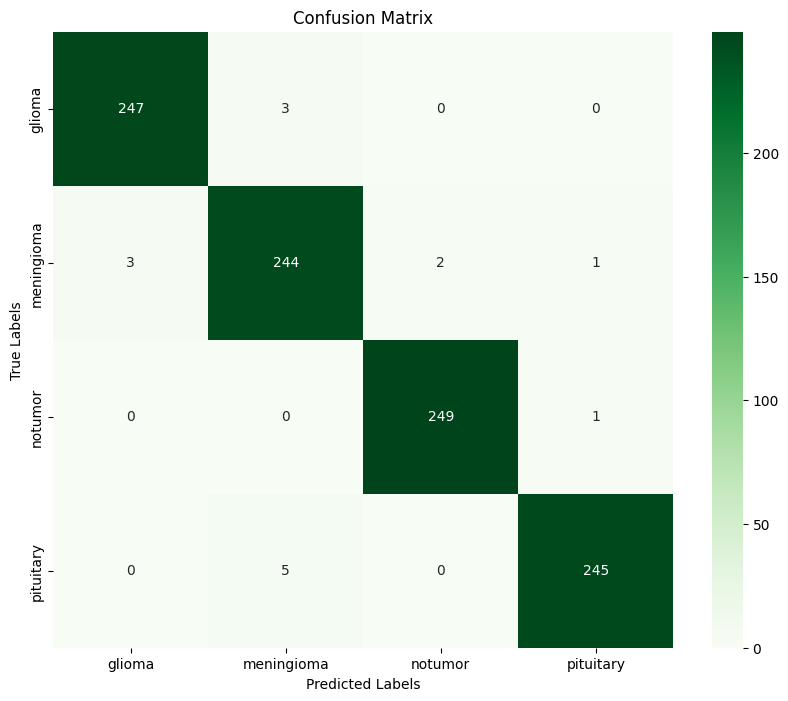

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_test_new, pred)
sns.heatmap(cm, ax=ax, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap='Greens')
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
plt.show()

In [11]:
model.save('EfficientNet-B0_Brain-Tumor_CLAHE.h5')
print("Model berhasil disimpan")

Model berhasil disimpan


In [12]:
import keras

In [13]:
keras.saving.save_model(model, 'EfficientNet-B0_Brain-Tumor_CLAHE.keras')
print("Model berhasil disimpan")

Model berhasil disimpan
